<a href="https://colab.research.google.com/github/Motwkel-Mohammed/People-Street-Data-Image/blob/main/CNN_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import random

from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [3]:
!git clone https://github.com/Motwkel-Mohammed/People-Street-Data-Image.git

Cloning into 'People-Street-Data-Image'...
remote: Enumerating objects: 2747, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 2747 (delta 0), reused 3 (delta 0), pack-reused 2744
Receiving objects: 100% (2747/2747), 152.40 MiB | 16.12 MiB/s, done.


# New Section

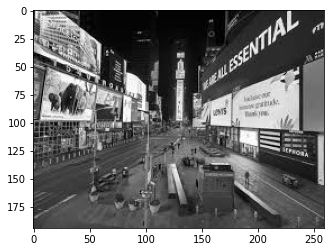

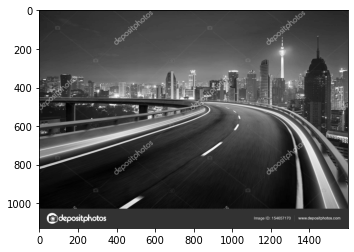

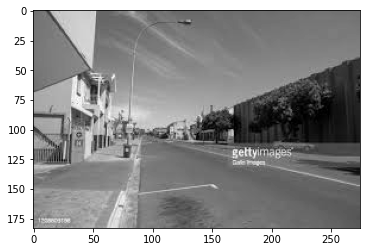

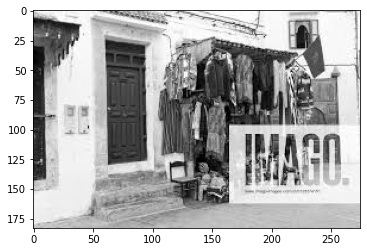

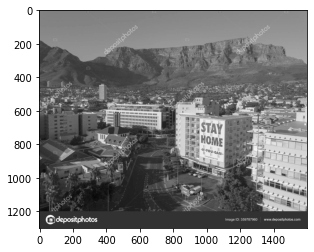

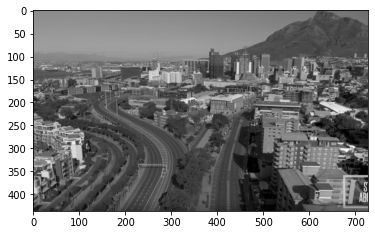

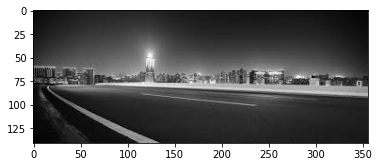

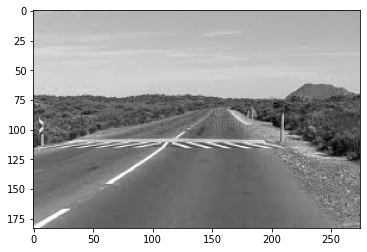

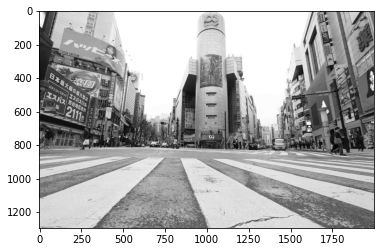

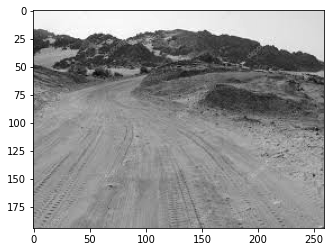

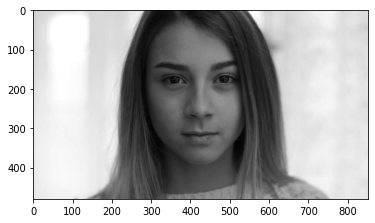

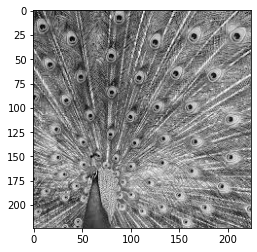

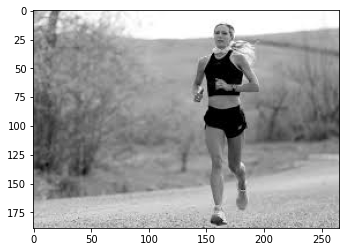

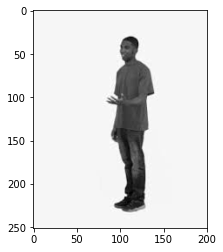

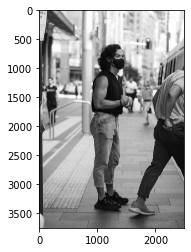

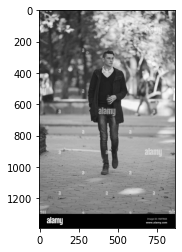

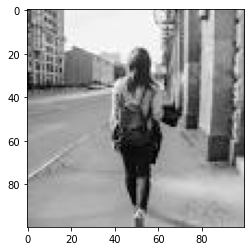

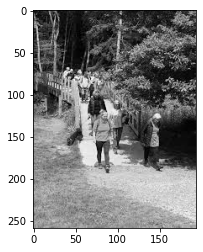

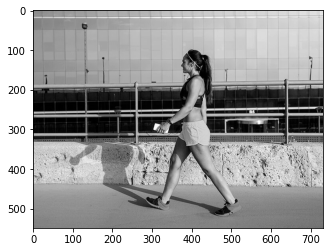

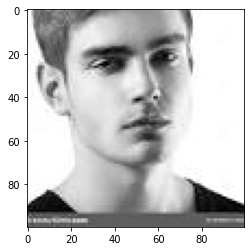

In [4]:
# Access data directory
DATADIR = '/content/People-Street-Data-Image/train'
CATEGORIES = ["street", "people"]
for category in CATEGORIES:  # do street and people 
    path = os.path.join(DATADIR,category)  # create path to street and people (train/street, .. train/people)
    x=0
    for img in os.listdir(path):  # iterate over each image per street and people
        x+=1
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array .. (train/street/1.jpg.., train/people/1.jpg..)
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!
        if x==10 : 
            break        

class_num = CATEGORIES.index(category) # 0,1

In [5]:
IMG_SIZE = 100
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do street and person

        path = os.path.join(DATADIR,category)  # create path to street and person
        class_num = CATEGORIES.index(category)  # get the classification  (0 or 1). 0=street 1=person

        for img in tqdm(os.listdir(path)):  # iterate over each image per street and person
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to .. array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data .. size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
           

create_training_data() # call function
print(len(training_data)) 


100%|██████████| 1084/1084 [00:03<00:00, 346.42it/s]

2039


In [6]:
random.shuffle(training_data) # Done shuffling
for sample in training_data[:10]: # show first 10
    print(sample[1]) # show the lable

0
1
0
1
1
0
1
1
1
1


In [7]:
# split the array to show image and lables seperatly
X_train = []
y_train = []
for features,label in training_data:
    X_train.append(features)
    y_train.append(label)

print(X_train[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))
X_train = np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE)

[[[[ 94]
   [102]
   [172]
   ...
   [ 80]
   [ 49]
   [ 68]]

  [[ 62]
   [ 73]
   [ 85]
   ...
   [ 79]
   [ 53]
   [ 55]]

  [[ 64]
   [ 37]
   [ 47]
   ...
   [ 78]
   [ 50]
   [ 52]]

  ...

  [[253]
   [253]
   [253]
   ...
   [ 68]
   [ 79]
   [ 77]]

  [[253]
   [253]
   [253]
   ...
   [118]
   [107]
   [139]]

  [[253]
   [253]
   [253]
   ...
   [114]
   [ 87]
   [125]]]]


In [8]:
# Buillding CNN:
KerasModel = keras.models.Sequential([
        keras.layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,1)),
        keras.layers.Conv2D(150,kernel_size=(3,3),activation='relu'),
        keras.layers.MaxPool2D(4,4),
        keras.layers.Conv2D(120,kernel_size=(3,3),activation='relu'),    
        keras.layers.Conv2D(80,kernel_size=(3,3),activation='relu'),    
        keras.layers.Conv2D(50,kernel_size=(3,3),activation='relu'),
        keras.layers.MaxPool2D(4,4),
        keras.layers.Flatten() ,    
        keras.layers.Dense(120,activation='relu') ,    
        keras.layers.Dense(100,activation='relu') ,    
        keras.layers.Dense(50,activation='relu') ,        
        keras.layers.Dropout(rate=0.5) ,            
        keras.layers.Dense(2,activation='softmax') ,    
        ])



In [9]:
# Run CNN:
KerasModel.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# show summary
print('Model Details are : ')
print(KerasModel.summary())


Model Details are : 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 200)       2000      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 150)       270150    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 150)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 120)       162120    
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 80)        86480     
                                                                 
 conv2d_4 (Conv2D)           (None, 18, 18, 50)        36050     
                                   

In [13]:
# Set a learning rate
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

earlystop = EarlyStopping(patience=10) # To prevent over fitting we will stop the learning after 10 .. epochs and val_loss value not decreased

# to stop or reduce if near overfiting
callbacks = [earlystop, learning_rate_reduction]

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=13)#test_size 20%

In [15]:
batch_size = 86
epochs = 100

X_train= np.array(X_train)
y_train= np.array(y_train)
X_val= np.array(X_val)
y_val= np.array(y_val)

history = KerasModel.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val),
                         steps_per_epoch=X_train.shape[0] // batch_size,
                         verbose=1, callbacks=callbacks)

Epoch 1/100
15/15 [==============================] - 19s 823ms/step - loss: 0.1087 - accuracy: 0.9594 - val_loss: 0.0718 - val_accuracy: 0.9725 - lr: 5.0000e-04
Epoch 2/100
15/15 [==============================] - 5s 329ms/step - loss: 0.0653 - accuracy: 0.9778 - val_loss: 0.0556 - val_accuracy: 0.9817 - lr: 5.0000e-04
Epoch 3/100
15/15 [==============================] - 5s 311ms/step - loss: 0.0668 - accuracy: 0.9801 - val_loss: 0.0571 - val_accuracy: 0.9847 - lr: 5.0000e-04
Epoch 4/100
15/15 [==============================] - 5s 312ms/step - loss: 0.0334 - accuracy: 0.9877 - val_loss: 0.0491 - val_accuracy: 0.9847 - lr: 5.0000e-04
Epoch 5/100
15/15 [==============================] - 5s 312ms/step - loss: 0.0181 - accuracy: 0.9969 - val_loss: 0.0599 - val_accuracy: 0.9786 - lr: 5.0000e-04
Epoch 6/100
15/15 [==============================] - 5s 312ms/step - loss: 0.0130 - accuracy: 0.9954 - val_loss: 0.0553 - val_accuracy: 0.9878 - lr: 5.0000e-04
Epoch 7/100
15/15 [====================

In [42]:
IMG_SIZE = 100
test_data = []

DATADIR = '/content/People-Street-Data-Image/test'

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to .. array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data .. size
                test_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
           

create_training_data() # call function
print(len(test_data)) 


100%|██████████| 439/439 [00:00<00:00, 732.53it/s]

760


In [43]:
random.shuffle(test_data) # Done shuffling
for sample in test_data[:10]: # show first 10
    print(sample[1]) # show the lable

1
1
0
1
1
0
1
1
1
1


In [44]:
# split the array to show image and lables seperatly
X_test = []
y_test = []
for features,label in test_data:
    X_test.append(features)
    y_test.append(label)

print(X_test[0].reshape(-1, IMG_SIZE, IMG_SIZE))
X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE)
y_test = np.array(y_test)

[[[218 221 215 ... 236 236 240]
  [218 221 215 ... 236 236 240]
  [218 221 215 ... 235 235 238]
  ...
  [209 222 215 ... 207 218 198]
  [219 221 214 ... 206 211 215]
  [220 212 206 ... 179 191 196]]]


In [45]:
test_loss, test_acc = KerasModel.evaluate(X_test ,y_test, verbose=1)
print('Accuracy is: ', test_acc)
print('Loss is: ', test_loss)

24/24 [==============================] - 1s 37ms/step - loss: 0.5553 - accuracy: 0.9263
Accuracy is:  0.9263157844543457
Loss is:  0.5553178787231445


In [46]:
prediction = KerasModel.predict(X_test)
print(prediction)

[[2.8602147e-07 9.9999976e-01]
 [1.1016007e-21 1.0000000e+00]
 [1.0000000e+00 5.6002848e-13]
 ...
 [1.0748145e-10 1.0000000e+00]
 [1.0000000e+00 3.3984476e-10]
 [7.6785362e-08 9.9999988e-01]]


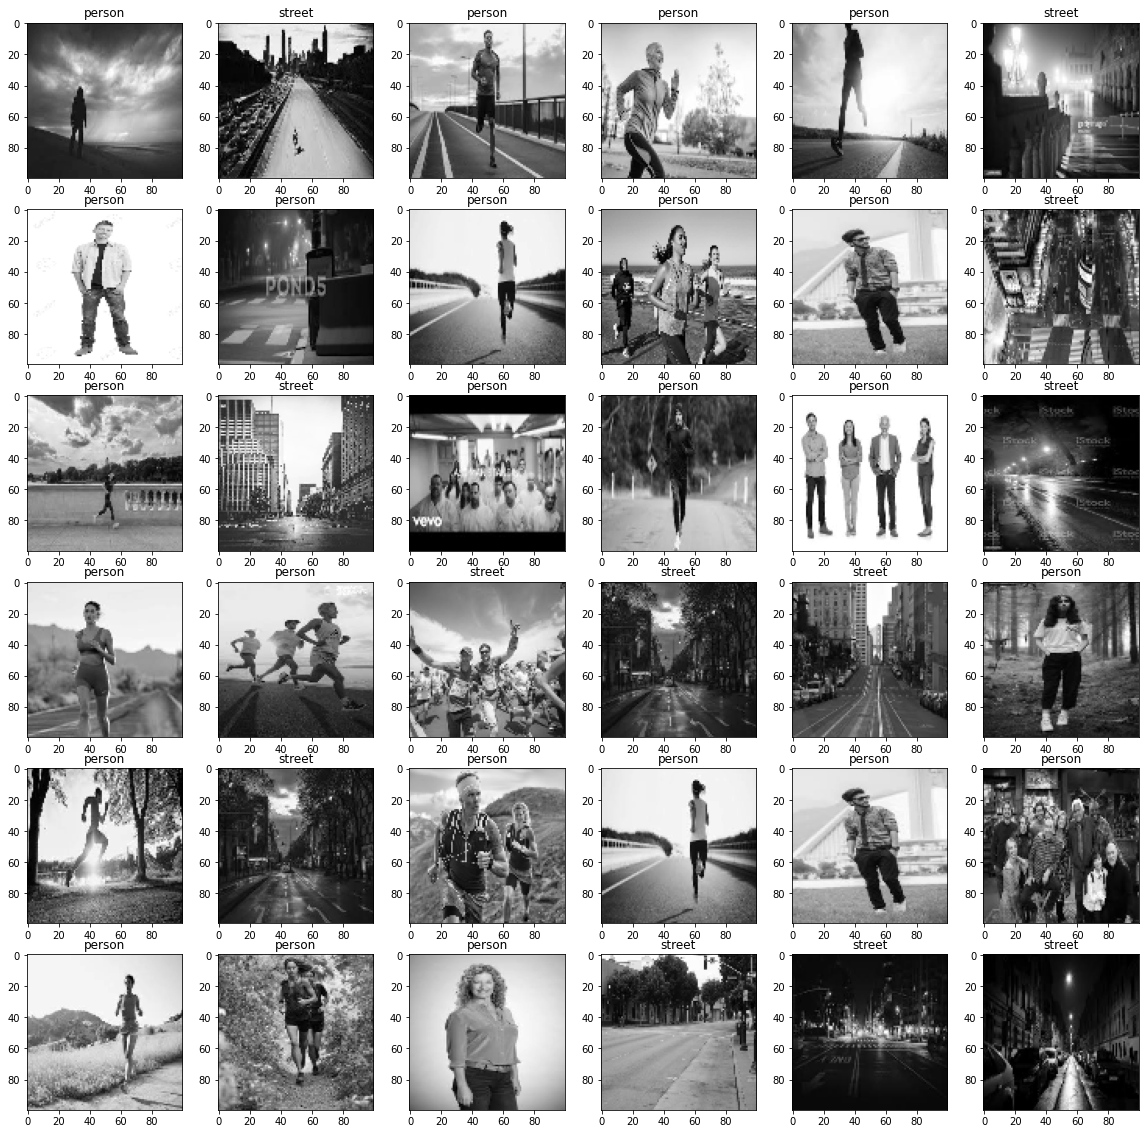

In [49]:
plt.figure(figsize=(20, 20)) 
for n,i in enumerate(list(np.random.randint(0, len(X_test),36))):
    plt.subplot(6, 6, n+1)
    plt.imshow(X_test[i], cmap=plt.cm.gray)
    i = np.argmax(prediction[i])
    if i == 1:
        plt.title('person')
    else:
        plt.title('street')
        